# LTEM simulations

## Some test for rewriting functions to use `df.Field` whenever possible

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(1)
#np.random.seed(1)

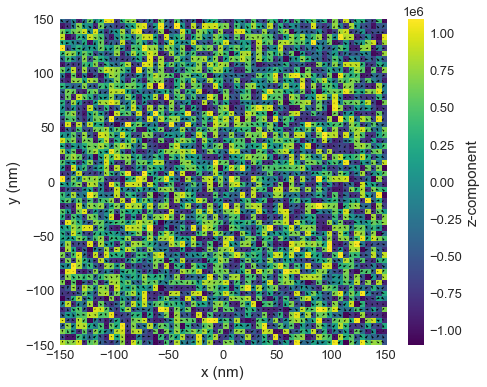

In [3]:
region = df.Region(p1=(-150e-9, -150e-9, 0), p2=(150e-9, 150e-9, 20e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name='Box2')

system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T') 
                 + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1)) 
                 + mm.Demag()
                 + mm.Zeeman(H=(0, 0, 2e5)))

Ms = 1.1e6

def m_fun(pos):
    return [2*random.random()-1 for i in range(3)]
    # return 2 * np.random.rand(3) - 1

# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
system.m.plane('z').mpl()

In [4]:
# NBVAL_IGNORE_OUTPUT
# minimize the energy
md = oc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner) [2021/07/08 12:09]... (9.4 s)


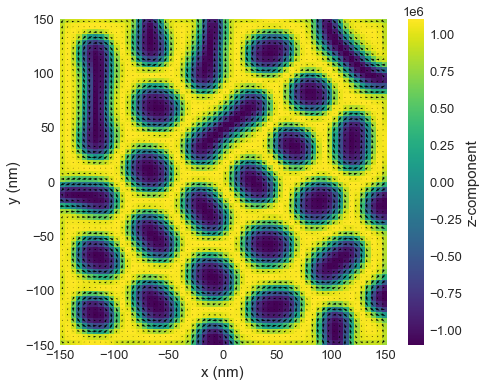

In [5]:
# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

In [6]:
m_projection = system.m.project('z')

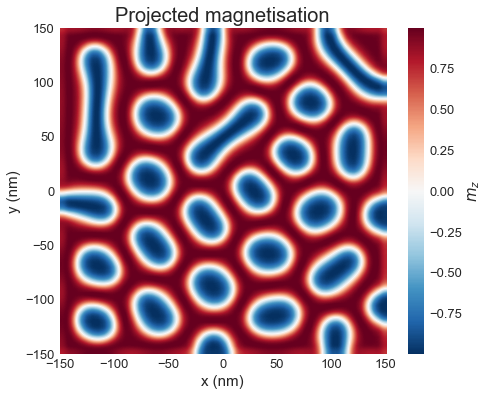

In [7]:
fig, ax = plt.subplots()
m_projection.orientation.z.mpl_scalar(ax=ax,
                                       cmap='RdBu_r',
                                       interpolation='spline16',
                                       colorbar_label=r'$m_z$')
ax.set_title('Projected magnetisation');

## Simulate LTEM

In [8]:
import mag2exp

In [9]:
phase, ft_phase = mag2exp.ltem_phase(system.m)

In [10]:
defocus = mag2exp.ltem_defocus_image(phase, U=300e3, Cs=8000, df_length=-0.4e-3)

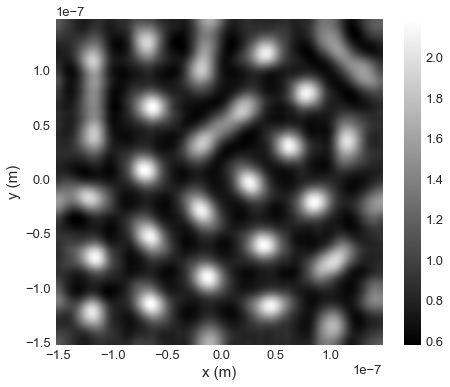

In [11]:
defocus.mpl_scalar(cmap='gray',
                   interpolation='spline16')

---
Phase in real space

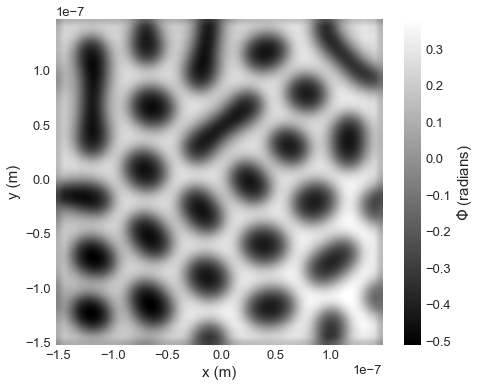

In [12]:
phase.real.mpl_scalar(cmap='gray',
                   interpolation='spline16',
                   colorbar_label=r'$\Phi$ (radians)')

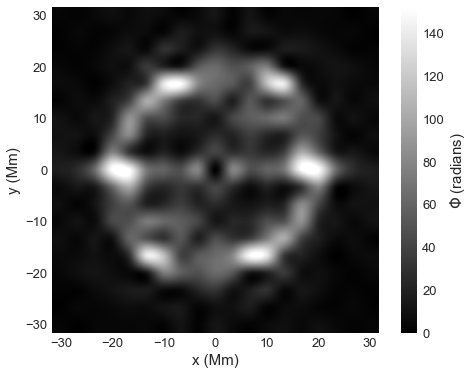

In [13]:
vals = np.sqrt((ft_phase.conjugate * ft_phase).array)

abs_field = df.Field(ft_phase.mesh, dim=ft_phase.dim, value=vals)

abs_field[df.Region(p1=(-30e6,-30e6,0), p2=(30e6,30e6,1))].plane('z').real.mpl_scalar(cmap='gray',
                   interpolation='spline16',
                   colorbar_label=r'$\Phi$ (radians)')

---
Cosine of the phase

In [14]:
cos_phase = df.Field(phase.mesh, dim=1, value=np.cos(phase.real.array * 15))

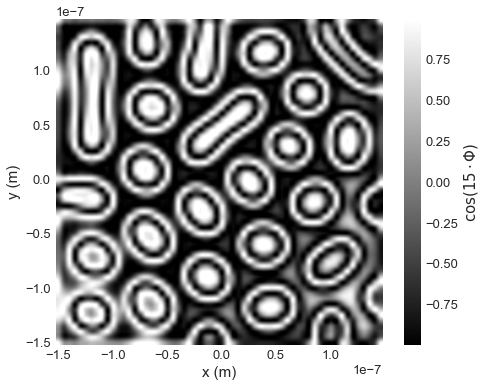

In [15]:
cos_phase.mpl_scalar(cmap='gray',
                     interpolation='spline16',
                     colorbar_label=r'$\cos(15\cdot\Phi)$')

---
Projected magnetisation

In [16]:
m_inplane_angle = df.Field(m_projection.mesh, dim=1,
                           value=np.arctan2(m_projection.y.array, m_projection.x.array))

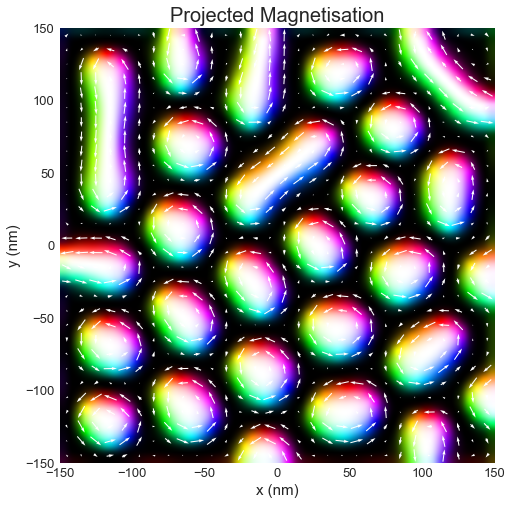

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
m_inplane_angle.mpl_scalar(ax=ax,
                           cmap='hsv',
                           interpolation='spline16',
                           lightness_field=-m_projection.z,
                           colorbar=False)
m_projection.plane('z', n=(30, 30)).mpl_vector(ax=ax,
                                               color='w',
                                               use_color=False)

ax.set_title('Projected Magnetisation');

---
Projected B-field calcuated from the phase

In [18]:
B_projected = -1 * phase.real.derivative('y') << phase.real.derivative('x')
B_angle = df.Field(B_projected.mesh, dim=1, value=np.arctan2(B_projected.y.array, B_projected.x.array))

In [19]:
B_plot = B_projected << B_angle

In [20]:
mag = np.sqrt(B_plot.x.array**2 + B_plot.y.array**2)
mag[0, 0, 0, 0] = 2 * np.max(mag)  # avoid pure white; "ruins" bottom left corner
lightness = df.Field(B_plot.mesh, dim=1, value=mag)

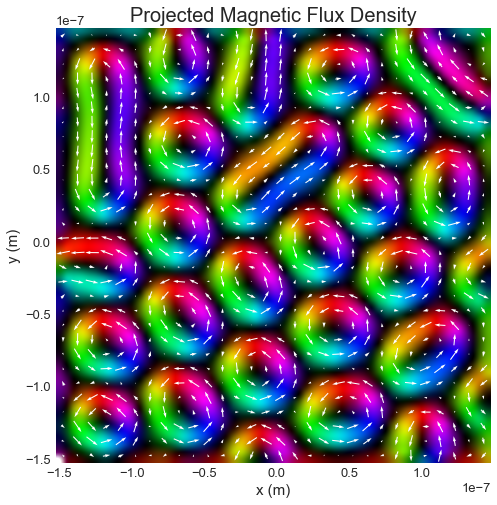

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
B_plot.z.mpl_scalar(ax=ax,
                    cmap='hsv',
                    interpolation='spline16',
                    lightness_field=lightness,
                    colorbar=False)
B_plot.plane('z', n=(30, 30)).mpl_vector(ax=ax, color='w', use_color=False)
ax.set_title('Projected Magnetic Flux Density');

We can observe a 180 degree phase shift in the colours compared to Sam's notebook. Is there an agreed-upon convention about the relation between colour and in-plane angle?

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import matplotlib.pyplot as plt
import mag2exp
import scipy.constants as constants

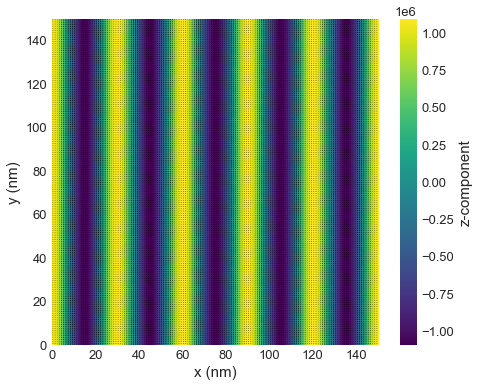

In [86]:
region = df.Region(p1=(0, 0, 0), p2=(150e-9, 150e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(1e-9, 1e-9, 1e-9))

Ms = 1.1e6

def m_fun(pos):
    x, y, z = pos
    q = 30e-9
    return [0, np.sin(2*np.pi*x/q), np.cos(2*np.pi*x/q)]

# create system with above geometry and initial magnetisation
field = df.Field(mesh, dim=3, value=m_fun, norm=Ms)
field.plane('z').mpl.plot()

In [87]:
phase, _ = mag2exp.ltem.phase(field)

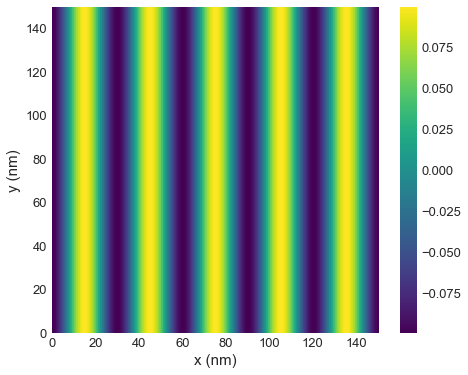

In [88]:
phase.mpl.plot()

In [89]:
phase.mesh.cell

(9.999999999999999e-10, 9.999999999999999e-10, 1.0000000000000007e-09)

In [290]:
def analytical_sol(pos):
    x, y, z = pos
    
    q = 30e-9
    analytical = - ((constants.e*constants.mu_0*Ms*10e-9)/(constants.h))
    analytical *= q * np.cos(2*np.pi*x/q)
    
    return analytical

def analytical_sol_2(pos):
    x, y, z = pos
    
    q = 30e-9
    analytical = - ((constants.e*constants.mu_0*Ms*10e-9)/(constants.h)) * q
    analytical *=  (np.cos(2*np.pi*x/q) - 0.25*(2*np.pi/q)**2*np.cos(2*np.pi*x/q) * (1e-9)**2)
    
    return analytical

def analytical_sol_3(pos):
    x, y, z = pos
    
    q = 30e-9
    analytical = - ((constants.e*constants.mu_0*Ms*10e-9)/(constants.h)) * q
    analytical *=  ((np.sin(2*np.pi*(0.5e-9)/q))/(2*np.pi*0.5e-9/q)) * np.cos(2*np.pi*x/q)
    
    return analytical

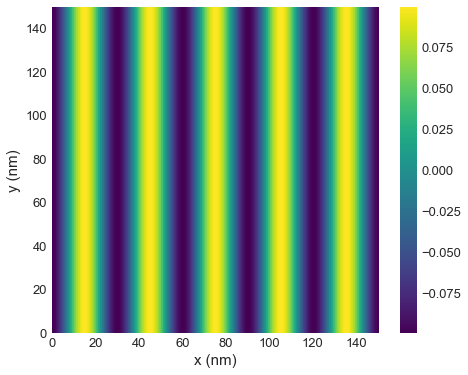

In [291]:
field2 = df.Field(phase.mesh, dim=1, value=analytical_sol_3)
field2.plane('z').mpl.scalar()

In [292]:
an_phase = field2.plane('z')

In [293]:
#cut = phase.line(p1=(30e-9, 50e-9,4.5e-09), p2=(120e-9, 50e-9,4.5e-09), n=90)
#an_cut = an_phase.line(p1=(30e-9, 50e-9,4.5e-09), p2=(120e-9, 50e-9,4.5e-09), n=90)
cut = phase.line(p1=(30e-9, 1e-9,4.5e-09), p2=(120e-9, 1e-9,4.5e-09), n=90)
an_cut = an_phase.line(p1=(30e-9, 1e-9,4.5e-09), p2=(120e-9, 1e-9,4.5e-09), n=90)

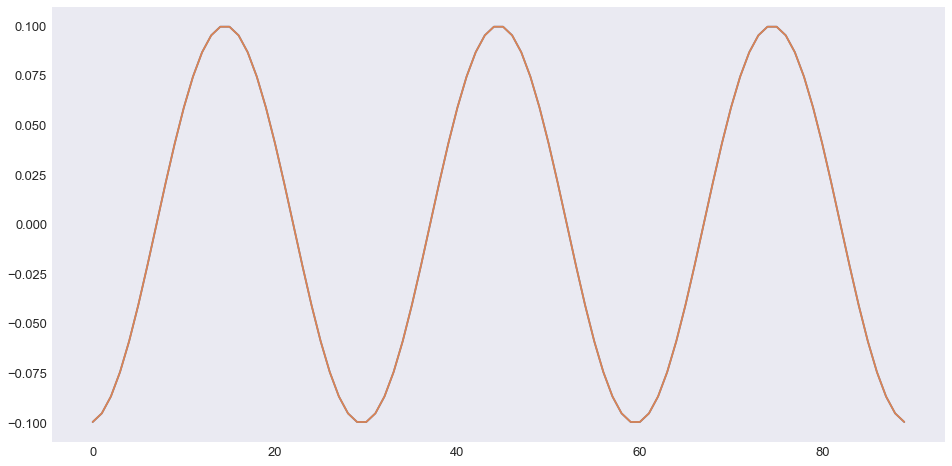

In [294]:
plt.figure(figsize=(16,8))
plt.plot(cut.data['v'].to_numpy())
plt.plot(an_cut.data['v'].to_numpy())

In [295]:
max(cut.data['v'].to_numpy())

0.09956298927970483

In [296]:
cut.data['v'].to_numpy()/an_cut.data['v'].to_numpy()

array([ 1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905, -0.77455031,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905, -2.36724652,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905, -0.70795247,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905, -0.50809073,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905,  1.00022905,  1.00022905,  1.00022905,
        1.00022905,  1.00022905, -0.89891151,  1.00022905,  1.00

In [267]:
q=30e-9
np.sin(2*np.pi*(0.5e-9)/q)/(2*np.pi*0.5e-9/q)

0.9981732973707995

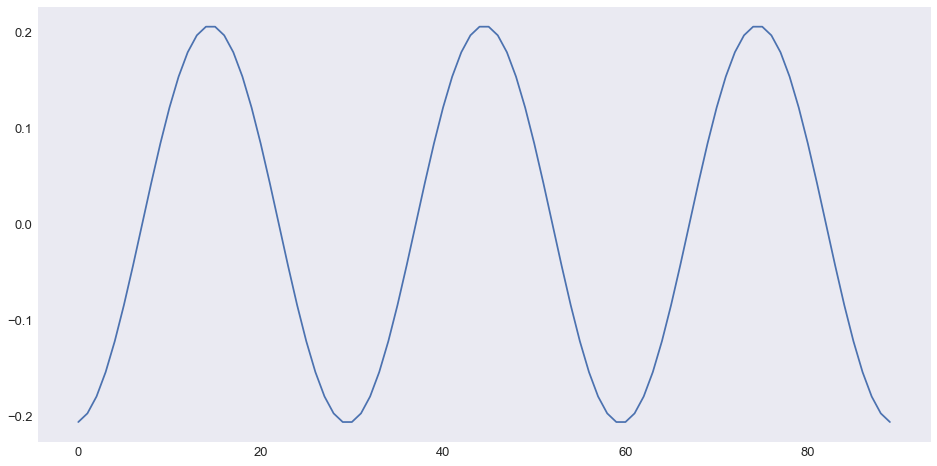

In [268]:
plt.figure(figsize=(16,8))
plt.plot(100*(cut.data['v'].to_numpy() - an_cut.data['v'].to_numpy())/max(cut.data['v'].to_numpy()))

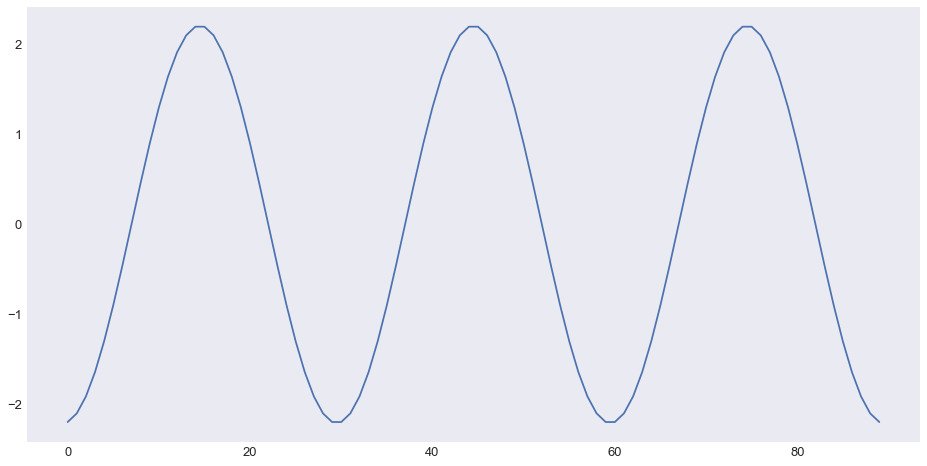

In [134]:
plt.figure(figsize=(16,8))
plt.plot(100*(cut.data['v'].to_numpy() - an_cut.data['v'].to_numpy()*0.998401925)/max(cut.data['v'].to_numpy()))

In [94]:
q = 30e-9
r = np.linspace(0+0.5e-9,90e-9-0.5e-9,91)
analytical = - ((constants.e*constants.mu_0*Ms*10e-9)/(constants.h))
analytical *= q * np.cos(2*np.pi*r/q)

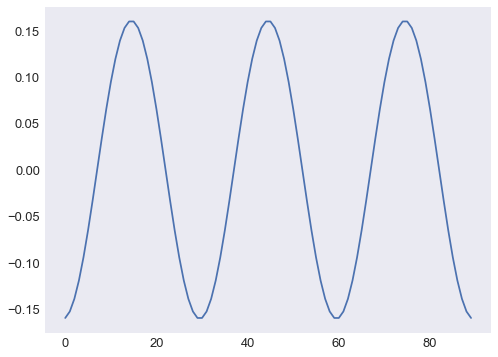

In [99]:
plt.plot(100*(analytical-cut.data['v'].to_numpy())/analytical.max())

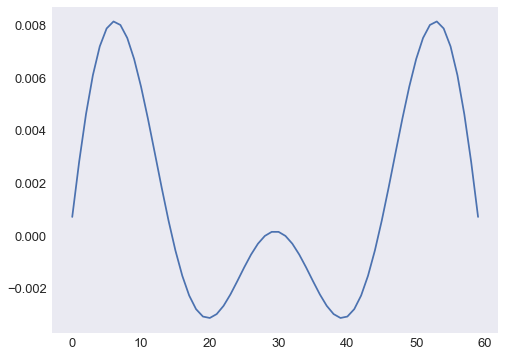

In [74]:
plt.plot((cut.data['v'].to_numpy() - analytical))

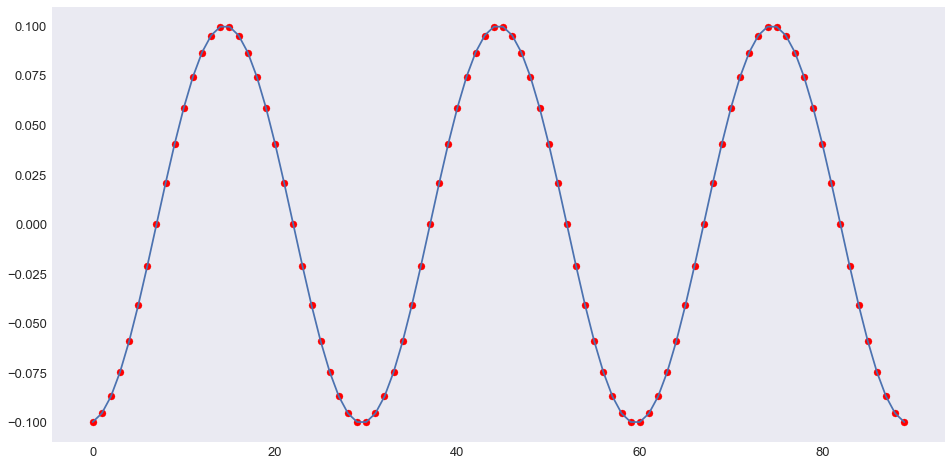

In [107]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(0,90),analytical)
plt.scatter(np.arange(0,90),cut.data['v'].to_numpy(), c='r')

TypeError: bad operand type for abs(): 'function'

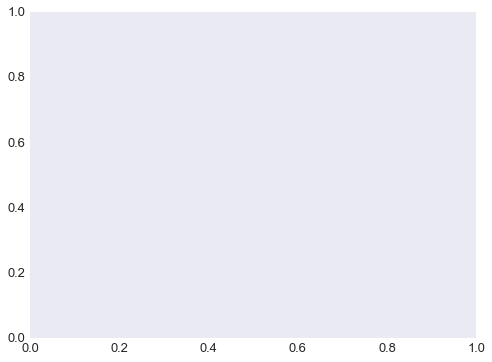

In [7]:
field2 = df.Field(mesh, dim=1, value=analytical_sol)
field2.plane('z').mpl.plot()

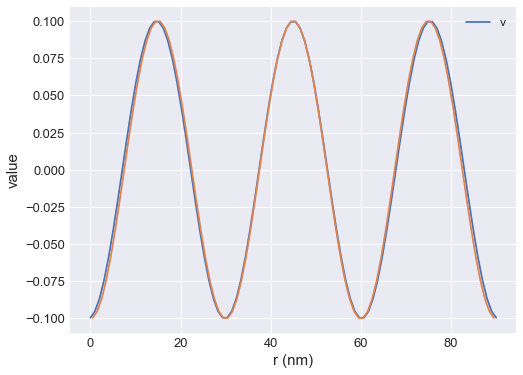

In [95]:
ax = plt.subplot()
cut.mpl(ax=ax)
plt.plot(r/1e-9, analytical)

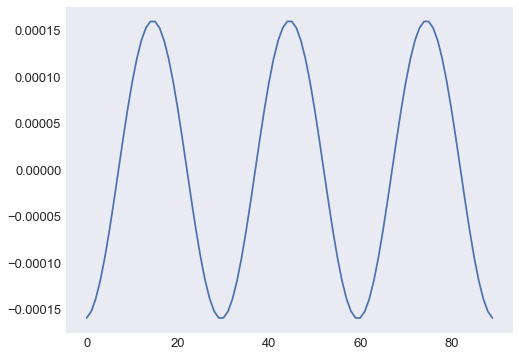

In [109]:
plt.plot(analytical-cut.data['v'].to_numpy())